# Example with CIFAR-10 dataset

#### Importing the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from tqdm import tqdm

#### Dataset Preparation

In [ ]:
# Normalizing the pixel values between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale()
])

# Loading and preprocessing the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting the dataset into training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 96700845.82it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 #### VAE Model Architecture

In [ ]:
next(iter(train_loader))[0][0].shape

torch.Size([1, 32, 32])

In [ ]:
# Defining the architecture of the AE, including the encoder and decoder components
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # Implementing the encoder using suitable layers
        self.encoder = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,32),
            nn.Tanh()
        )

        # Implementing the decoder with layers that mirror the encoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256,512),
            nn.LeakyReLU(),
            nn.Linear(512,1024),
            nn.Sigmoid()
        )

    def forward(self, x):
        original_shape = x.shape
        x = torch.flatten(x, start_dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(original_shape)
        return x

In [ ]:
model = AE()

In [ ]:
summary(model, (1,32,32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         524,800
         LeakyReLU-2                  [-1, 512]               0
       BatchNorm1d-3                  [-1, 512]           1,024
            Linear-4                  [-1, 256]         131,328
         LeakyReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
            Linear-7                  [-1, 128]          32,896
         LeakyReLU-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 64]           8,256
        LeakyReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 32]           2,080
             Tanh-13                   [-1, 32]               0
           Linear-14                   

#### Loss Function and Training

In [ ]:
# Initializing the AE model
ae = AE()
# Configuring the optimizer and learning rate
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

def train_step(model, x, optimizer):
    optimizer.zero_grad()
    reconstructed = model(x)
    loss = nn.functional.mse_loss(reconstructed, x)
    loss.backward()
    optimizer.step()
    return loss.item()

def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(train_loader)
        for batch_idx, (data, _) in enumerate(pbar):
            loss = train_step(model, data, optimizer)
            total_loss += loss
            # tqdm decoration
            pbar.set_description(f"Epoch {epoch+1}/{epochs}: ")
            pbar.set_postfix({"loss": loss, "average loss": total_loss/(batch_idx+1)})

# Training the VAE
train(ae, train_loader, optimizer, epochs=60)

Epoch 60/60: : 100%|██████████| 782/782 [00:38<00:00, 20.40it/s, loss=0.192, average loss=0.146]


 #### Reconstructing Input Data

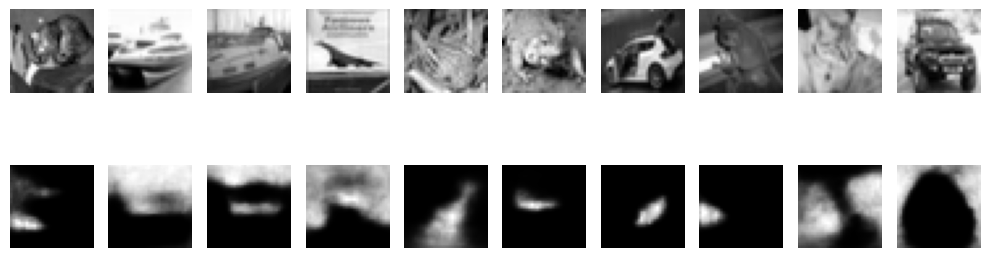

In [ ]:
def reconstruct_input(model, x):
    model.eval()
    with torch.no_grad():
        reconstructed = model(x)
    return reconstructed

# Reconstructing input data
sample_input, _ = next(iter(test_loader))
reconstructed_output = reconstruct_input(ae, sample_input)

# Visualizing the original input and its reconstructed counterpart
def denormalize(image):
    image = image / 2 + 0.5
    return np.transpose(image, (1, 2, 0))

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
for i in range(10):
    axes[0, i].imshow(denormalize(sample_input[i].numpy()), cmap="gray")
    axes[0, i].axis('off')
    axes[1, i].imshow(denormalize(reconstructed_output[i].numpy()), cmap="gray")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

### The result is not the best. However, we can see that the model is learning the features of the images.